In [2]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import train_test_split
# !wc -l data/multiple_muts_train_onehot.csv
# cd ../DeepCollisionalCrossSection/ # forget about this not avail

### Load data from Rafael

# tensorflow should be installed version (if not provided already in colac)
# pip install tensorflow==1.13.2
# pip install tensorflow-gpu==1.13.2
# import main functions



In [ ]:
## utils import and function
import pandas as pd
import numpy as np

def get_np_from_series(series):
    result = series.apply(lambda x: 
                               np.fromstring(
                                   x.replace('\n','')
                                    .replace('[','')
                                    .replace(']','')
                                    .replace('  ',' '), sep=' '))
    return result

In [3]:
df_train_single = pd.read_csv('data/single_muts_train_onehot.csv')
df_train_single = df_train_single[~np.isnan(df_train_single['stabilityscore'])]
X_single = np.array(get_np_from_series(df_train_single['Sequence_onehot']))
y_single = df_train_single['stabilityscore']
# type(np.array(X[0]))

X_single = X_single[~np.isnan(y_single)]
y_single = y_single[~np.isnan(y_single)]

In [4]:
df_train_multiple = pd.read_csv('data/multiple_muts_train_onehot.csv')
X_mult = np.array(get_np_from_series(df_train_multiple['Sequence_onehot']))
y_mult = df_train_multiple['stabilityscore']
# type(np.array(X[0]))

X_mult = X_mult[~np.isnan(y_mult)]
y_mult = y_mult[~np.isnan(y_mult)]

In [5]:
df = pd.concat([df_train_single, df_train_multiple])

In [ ]:
import seaborn as sns

In [16]:
df['protein'] = df['name'].str.split('_').str[0]
df['rep'] = df['name'].str.split('_').str[1]
df.groupby(['rep', 'protein']).size()

rep       protein
0142.pdb  HHH         641
0882.pdb  EHEE        578
rd1       EEHEE      2708
          EHEE       2354
          HEEH       2364
          HHH        2338
rd2       EEHEE      3087
          EHEE       3585
          HEEH       3372
          HHH        1168
rd3       EEHEE      6889
          EHEE       1187
          HEEH       6221
          HHH        1245
dtype: int64

In [587]:
import keras
from keras import Input
from keras.layers import Dense
import pandas as pd
import numpy as np

In [943]:
def get_input_features(df, sse_simple=False):
    X1 = []
    for s in df['sequence']:
        ohe = onehot_encode_aa(s)
        X1.append(ohe.flatten())
    X1 = np.array(X1)

    
    X2 = []
    if not sse_simple:
        X2 = []
        for s in df['secondary_structure']:
            ohe = onehot_encode_ss(s)
            X2.append(ohe.flatten())
        X2 = np.array(X2)
    else:
        # simpler version to make X2
        ss = []
        pos_by_ss = {ssi: i for i, ssi in enumerate(df['secondary_structure'].value_counts().index)}
        for ssi in df['secondary_structure']:
            # print(ssi, pos_by_ss[ssi])
            ss.append([0 if pos_by_ss[ssi] != i else 1 for i in range(len(pos_by_ss))])
        X2 = np.array(ss)

    return (X1, X2)

def get_color_ss(series_ss):
    color_by_struct = {'TEEEETTEEEETTTHHHHHHHHHHHHHHHTTTEEEETTEEEET': '#e41a1c',
                      'THHHHHHHHHHHHHTTEEEETTEEEETTTHHHHHHHHHHHHHT': '#377eb8',
                      'THHHHHHHHHHHHHTTTHHHHHHHHHHHTTTHHHHHHHHHHHT': '#4daf4a',
                      'TTTTEEEEETTHHHHHHHHHHHHHHTTTEEEEEETTEEEEEET': '#984ea3'}

    return series_ss.map(color_by_struct)


def get_color_ss(series_ss):
    color_by_struct = {'TEEEETTEEEETTTHHHHHHHHHHHHHHHTTTEEEETTEEEET': '#e41a1c',
                      'THHHHHHHHHHHHHTTEEEETTEEEETTTHHHHHHHHHHHHHT': '#377eb8',
                      'THHHHHHHHHHHHHTTTHHHHHHHHHHHTTTHHHHHHHHHHHT': '#4daf4a',
                      'TTTTEEEEETTHHHHHHHHHHHHHHTTTEEEEEETTEEEEEET': '#984ea3'}

    return series_ss.map(color_by_struct)

import pandas as pd
import numpy as np
import Bio.PDB
def onehot_encode_aa(sequence):
    """ Converts string-format amino acid sequence to one-hot encoded format """
    aa_indices = []
    for aa in sequence:
         try:
             aa_index = Bio.PDB.Polypeptide.one_to_index(aa)
         except:
             aa_index = 20 # account for non-standard aa
         aa_indices.append(aa_index)
    
    sequence_onehot = np.zeros((len(aa_indices), 20))
    sequence_onehot[np.arange(len(aa_indices)), aa_indices] = 1
    return sequence_onehot

def onehot_encode_ss(sequence):
    """ Converts string-format secondary structure sequence to one-hot encoded format """
    ss_dict = {"E": 0, "T": 1, "S": 2, "H": 3} # {"-": 0, 
    ss_indices = []
    for ss in sequence:
         try:
             ss_index = ss_dict[ss]
         except:
             aa_index = 20 # account for non-standard aa
         ss_indices.append(ss_index)
    
    sequence_onehot = np.zeros((len(ss_indices), len(ss_dict)))
    sequence_onehot[np.arange(len(ss_indices)), ss_indices] = 1
    return sequence_onehot

In [1065]:
# plottting
from matplotlib import rcParams
def plot(model, x1, x2, y, color, dpi=80, figsize=[5, 5], axis='equal'):
    
    ax = plt.subplot()

    y_pred = model.predict([x1, x2])
    rcParams['figure.figsize'] = figsize
    rcParams['figure.dpi'] = dpi
    
    r = pearsonr(y_pred.flatten(), y)[0]
    rho = spearmanr(y_pred.flatten(), y)[0]
    r2 = r2_score(y_pred, y)
    
    pearson_title = 'Pearson=%.2f' % r
    spearman_title = '\u03C1=%.2f' % rho
    print('xmin/xmax', min(y_pred.flatten()), max(y_pred.flatten()))
    plt.scatter(y_pred, y, c=color, s=6)
    
    if axis is not None:
        plt.axis('equal')
    
    plt.xlabel('predicted')
    plt.ylabel('measured')
    plt.title('N=%i, %s, %s' % (y.shape[0], pearson_title, spearman_title))
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return [r, rho, r2]

    

In [930]:
def get_model(n_aa=860, n_ss=172):

    # remove NA (they mess up training loss)
    np.bincount(np.isnan(y))

    float_input = Input(shape=(1, ))
    
    one_hot_input = Input(shape=(n_aa,) )
    second_hot_input = Input(shape=(n_ss,) )
    first_dense = Dense(n_aa)(one_hot_input)
    second_dense = Dense(n_ss)(second_hot_input)
    merge_one = keras.layers.Concatenate()([first_dense, second_dense])

    dense_inner = Dense(864)(merge_one)

    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(432)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(210)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(105)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)
    dense_inner = Dense(50)(dense_inner)
    dense_inner = keras.layers.Dropout(0.5)(dense_inner)    

    dense_output = Dense(1)(dense_inner)
    model = keras.Model(inputs=[one_hot_input, second_hot_input], outputs=dense_output)
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy', 'mean_squared_error'])

    model.summary()
    return model


In [944]:
def prepare_train_test(df, split=False, use_simple_sse=True):
    #padded_sequences = pad_sequences(sequences, maxlen=SEQUENCE_SIZE, padding='post', truncating='post', value=0)
    print(df.shape)
    df = df[~np.isnan(df['stabilityscore'])]
    X1, X2 = get_input_features(df, sse_simple=use_simple_sse)
    y = np.array(df['stabilityscore'])

    print(X1.shape, X2.shape, y.shape)
    # remove nans
    X1 = X1[~np.isnan(y)]
    X2 = X2[~np.isnan(y)]
    y = y[~np.isnan(y)]

    if split:
        x_train, x_val, y_train, y_val = train_test_split(pd.DataFrame(np.concatenate([X1, X2], axis=1)), y, test_size=0.25)    
        idx_train = x_train.index
        idx_val = x_val.index
        x_train = np.array(x_train)
        x_val = np.array(x_val)
        return x_train, x_val, y_train, y_val, idx_train, idx_val
    else:
        X_test = np.concatenate([X1, X2], axis=1)
        return X_test, y


In [842]:
from os.path import exists
import pickle


In [972]:
use_all = [False, True]
use_simple_sse = [False, True]
n_epochs = [5, 10, 50]

queries = [[a, b, c] for c in n_epochs for a in use_all for b in use_simple_sse]

In [1067]:
overwrite = False

res = []
for q in queries[4:]:
    model = None
    
    use_all, use_complex_sse, n_epochs = q
    print(q)

    bkp_path_single = 'model_%s_%s_%i_epochs.pkl' % ('singlendouble' if use_all else 'single', 'ssecomplex' if not use_simple_sse else 'ssesimple', n_epochs)
    print(exists(bkp_path_single), bkp_path_single)
    
    if not 'model_single_ssesimple_50_epochs' in bkp_path_single:
        continue
        
    if not exists(bkp_path_single) or overwrite:
        
        model = get_model(n_aa=860, n_ss=4 if use_simple_sse else 172)
        
        df = df_train_single if not use_all else pd.concat([df_train_single, df_train_multiple]).copy()
        
        x_train, x_val, y_train, y_val, idx_train, idx_val = prepare_train_test(df, split=True, use_simple_sse=use_simple_sse)
        n_one_hot_per_feature_aa = 860
        x1_train = x_train[:,:n_one_hot_per_feature_aa]
        x2_train = x_train[:,n_one_hot_per_feature_aa:]
        x1_val = x_val[:,:n_one_hot_per_feature_aa]
        x2_val = x_val[:,n_one_hot_per_feature_aa:]
        print(x1_train.shape, x2_train.shape)

        model.fit([x1_train, x2_train], y_train, epochs=n_epochs, validation_data=([x1_val, x2_val], y_val))

        print('saving...')
        pickle.dump(model, open(bkp_path_single, 'wb'))

    print('loading...')    
    model = pickle.load(open(bkp_path_single, 'rb'))
    
    
    
    ### model evaluation in single mut data
    df_test = pd.read_csv('single_muts_test.csv')
    df_test = df_test[~np.isnan(df_test['stabilityscore'])]

    x_test, y_test = prepare_train_test(df_test, split=False)

    n_one_hot_per_feature_aa = 860
    x1_test = x_test[:,:n_one_hot_per_feature_aa]
    x2_test = x_test[:,n_one_hot_per_feature_aa:]

    # plot training
    rcParams['figure.figsize'] = [5, 5]
    r, rho, r2 = plot(model, x1_train, x2_train, y_train, color=get_color_ss(df.iloc[idx_train]['secondary_structure']), dpi=120)
    plt.savefig(bkp_path_single.replace('.pkl', '_single.train.png'))
    plt.close()
    
    res.append([use_all, use_complex_sse, n_epochs, 'single.train'] + [r, rho, r2])

    # test data (single mutants)
    df_test = pd.read_csv('single_muts_test.csv')
    df_test = df_test[~np.isnan(df_test['stabilityscore'])]
    x_test, y_test = prepare_train_test(df_test, split=False, use_simple_sse=use_simple_sse)
    n_one_hot_per_feature_aa = 860
    x1_test = x_test[:,:n_one_hot_per_feature_aa]
    x2_test = x_test[:,n_one_hot_per_feature_aa:]
    
    r, rho, r2 = plot(model, x1_test, x2_test, y_test, color=get_color_ss(df_test['secondary_structure']), dpi=120)
    plt.savefig(bkp_path_single.replace('.pkl', '_single.test.png'))
    plt.close()
    
    res.append([use_all, use_complex_sse, n_epochs, 'single.test'] + [r, rho, r2])
    
    
    # multiple mutants
    df_test = pd.read_csv('data/multiple_muts_train_onehot.csv')
    df_test = df_test[~np.isnan(df_test['stabilityscore'])]
    x1_test, x2_test = get_input_features(df_test, sse_simple=use_simple_sse)
    y_test = df_test['stabilityscore']
    # type(np.array(X[0]))
    x1_test = x1_test[~np.isnan(y_test)]
    x2_test = x2_test[~np.isnan(y_test)]
    y_test = y_test[~np.isnan(y_test)]
    
    r, rho, r2 = plot(model, x1_test, x2_test, y_test, color=get_color_ss(df_test['secondary_structure']))
    
    plt.xlim([-1.5, 1.5])
    plt.savefig(bkp_path_single.replace('.pkl', '_mult.test.png'))
    plt.close()

    res.append([use_all, use_complex_sse, n_epochs, 'mult.test'] + [r, rho, r2])
    
assert False




[False, False, 10]
True model_single_ssesimple_10_epochs.pkl
[False, True, 10]
True model_single_ssesimple_10_epochs.pkl
[True, False, 10]
True model_singlendouble_ssesimple_10_epochs.pkl
[True, True, 10]
True model_singlendouble_ssesimple_10_epochs.pkl
[False, False, 50]
True model_single_ssesimple_50_epochs.pkl
loading...
(2138, 5)
(2138, 860) (2138, 4) (2138,)
xmin/xmax -1.64376 2.2414517
(2138, 5)
(2138, 860) (2138, 4) (2138,)
xmin/xmax 0.27689308 1.8699166
xmin/xmax -1.64376 2.2414517
[False, True, 50]
True model_single_ssesimple_50_epochs.pkl
loading...
(2138, 5)
(2138, 860) (2138, 4) (2138,)
xmin/xmax -1.64376 2.2414517
(2138, 5)
(2138, 860) (2138, 4) (2138,)
xmin/xmax 0.27689308 1.8699166
xmin/xmax -1.64376 2.2414517
[True, False, 50]
True model_singlendouble_ssesimple_50_epochs.pkl
[True, True, 50]
True model_singlendouble_ssesimple_50_epochs.pkl


AssertionError: 

In [1058]:
x1_test.shape, x2_test.shape

((29156, 860), (29156, 4))

In [1064]:
!wc -l multiple_muts_test.csv  

7300 multiple_muts_test.csv


In [1055]:
r, rho, r2 = plot(model, x1_test, x2_test, y_test, color=get_color_ss(df_test['secondary_structure']), axis=None, dpi=120)

plt.xlim([-1.0, 1.5])
plt.savefig(bkp_path_single.replace('.pkl', '_mult.test.png'))
plt.close()

xmin/xmax -0.5272057 1.0635368


In [993]:
res = pd.DataFrame(res, columns=['use.all', 'use.complex', 'n.epochs', 'label', 'r', 'rho', 'r2'])

In [ ]:
sns.

In [996]:
res.sort_values('r', ascending=False)

,use.all,use.complex,n.epochs,label,r,rho,r2
12,False,False,50,single.train,0.862460,0.857004,0.543666
15,False,True,50,single.train,0.862460,0.857004,0.543666
13,False,False,50,single.test,0.828493,0.827880,0.453409
16,False,True,50,single.test,0.828493,0.827880,0.453409
0,False,False,10,single.train,0.793537,0.818871,-0.258190
3,False,True,10,single.train,0.793537,0.818871,-0.258190
9,True,True,10,single.train,0.783459,0.677628,0.150204
6,True,False,10,single.train,0.783459,0.677628,0.150204
21,True,True,50,single.train,0.783032,0.673813,-0.747556
18,True,False,50,single.train,0.783032,0.673813,-0.747556


In [1000]:
import seaborn as sns

In [1007]:
grp

,use.all,use.complex,n.epochs,label,r,rho,r2
0,False,False,10,single.train,0.793537,0.818871,-0.258190
3,False,True,10,single.train,0.793537,0.818871,-0.258190
6,True,False,10,single.train,0.783459,0.677628,0.150204
9,True,True,10,single.train,0.783459,0.677628,0.150204
12,False,False,50,single.train,0.862460,0.857004,0.543666
15,False,True,50,single.train,0.862460,0.857004,0.543666
18,True,False,50,single.train,0.783032,0.673813,-0.747556
21,True,True,50,single.train,0.783032,0.673813,-0.747556


In [1010]:
res['k.full'] = res['label'] + '.' + np.where(res['use.all'], 'all', 'single')

In [1023]:
grp

,use.all,use.complex,n.epochs,label,r,rho,r2,k.full
13,False,False,50,single.test,0.828493,0.827880,0.453409,single.test.single
16,False,True,50,single.test,0.828493,0.827880,0.453409,single.test.single
19,True,False,50,single.test,0.756418,0.766517,-2.581959,single.test.all
22,True,True,50,single.test,0.756418,0.766517,-2.581959,single.test.all


single.test (4, 8)


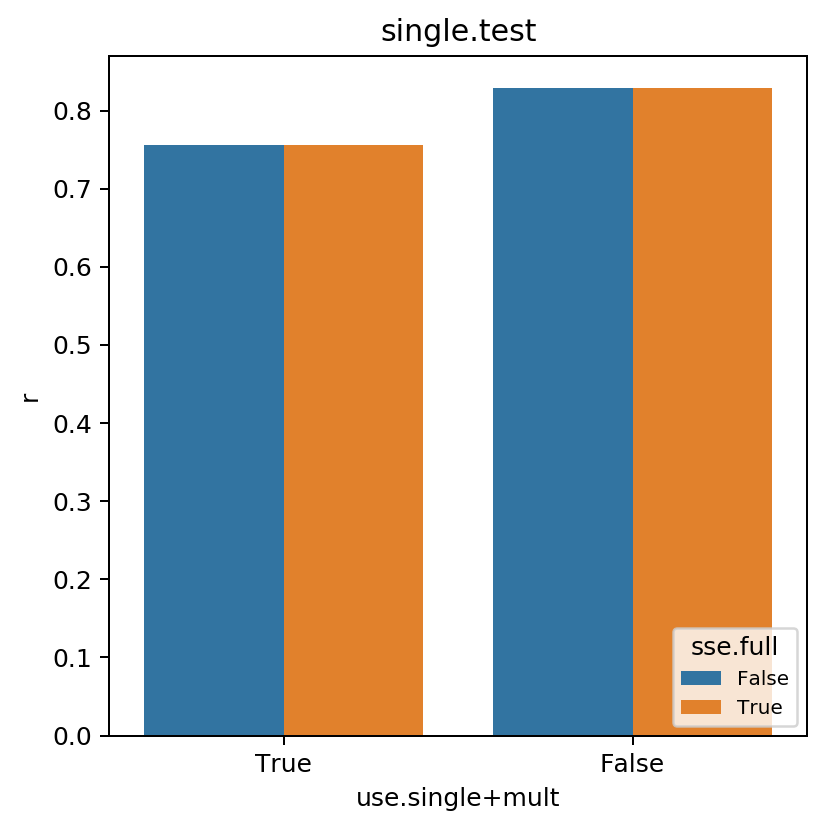

In [1039]:
label = 'single.test'
grp = res[(res['label'] == 'single.test') & (res['n.epochs'] == 50)]

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 180

print(label, grp.shape)
sns.barplot(data=grp, x='use.all', hue='use.complex', y='r', order=[True, False])
plt.xlabel('use.single+mult')
plt.title(label)
plt.legend(fontsize=8, loc='lower right', title='sse.full')
pi += 1

mult.test (4, 8)


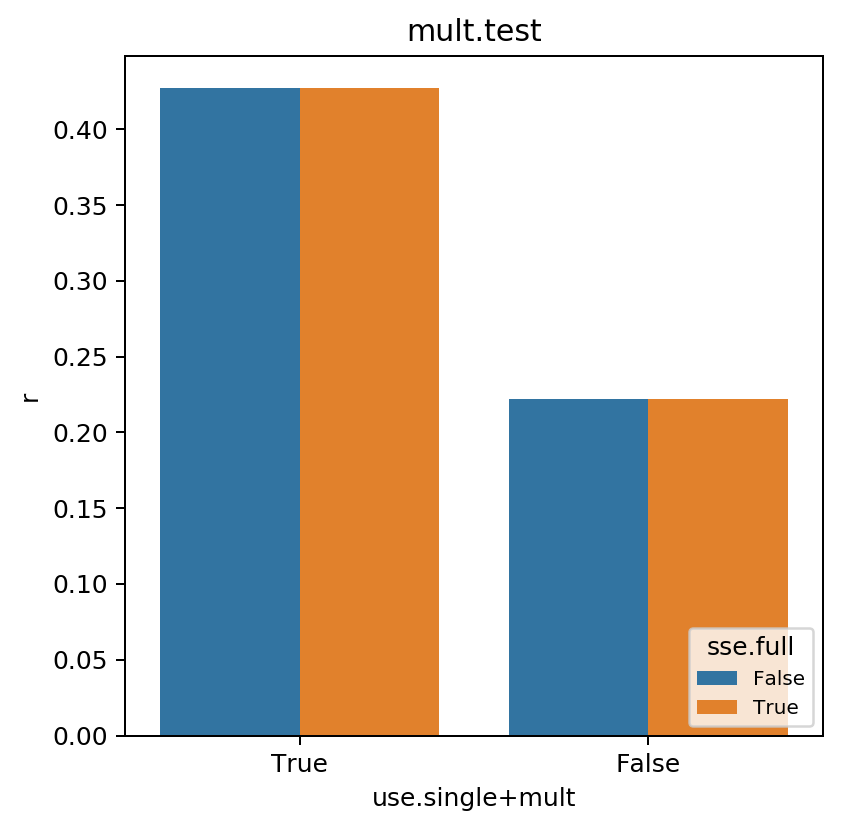

In [1041]:
label = 'mult.test'
grp = res[(res['label'] == label) & (res['n.epochs'] == 50)]

rcParams['figure.figsize'] = 5, 5
print(label, grp.shape)
sns.barplot(data=grp, x='use.all', hue='use.complex', y='r', order=[True, False])
plt.xlabel('use.single+mult')
plt.title(label)
plt.legend(fontsize=8, loc='lower right', title='sse.full')
pi += 1

mult.test.all (4, 8)
mult.test.single (4, 8)
single.test.all (4, 8)
single.test.single (4, 8)
single.train.all (4, 8)
single.train.single (4, 8)


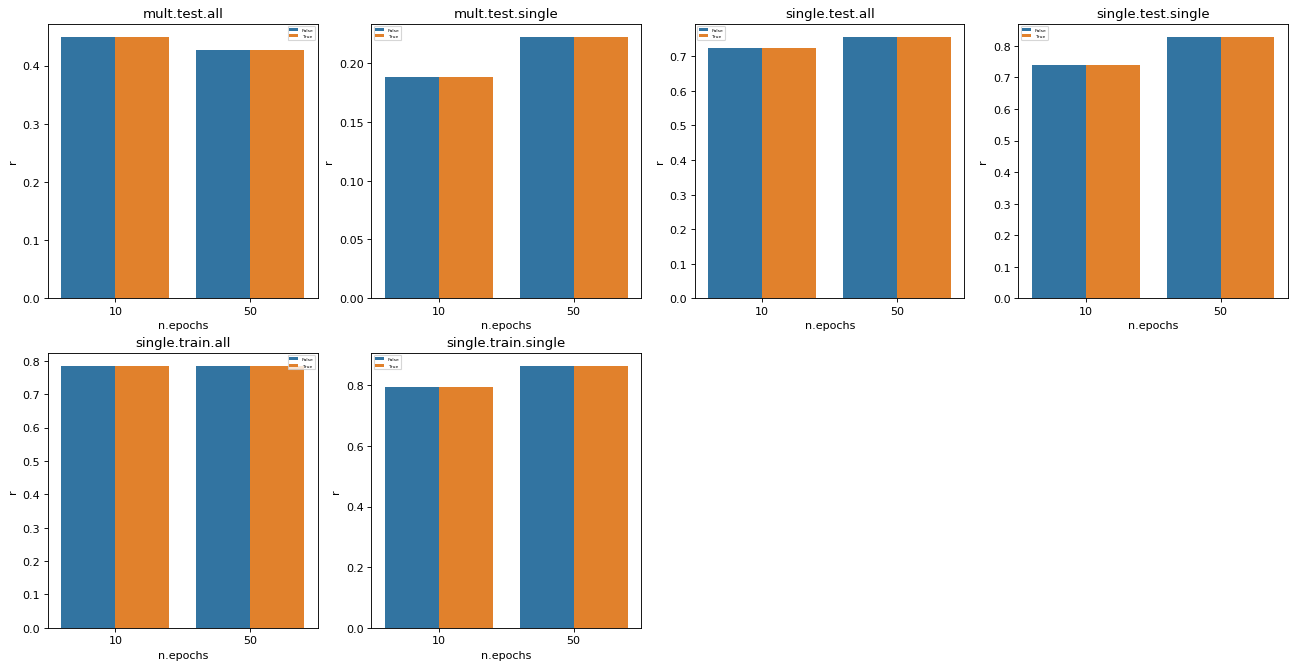

In [1016]:
rcParams['figure.figsize'] = 20, 10
pi = 0
for label, grp in res.groupby('k.full'):
    plt.subplot(2, 4, pi + 1)
    print(label, grp.shape)
    sns.barplot(data=grp, x='n.epochs', hue='use.complex', y='r')
    plt.title(label)
    plt.legend(fontsize=4)
    pi += 1

### Testing data (single mutants)